<a href="https://colab.research.google.com/github/angelinakhatiwada/Emotion-Detection-in-Song-Lyrics/blob/main/Emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion detection in the song lyrics

- Khatiwada Angelina
- Data Science and Economics, UNIMI
- Oct 2021

### Part 3: Emotion classification: text preprocessing, feature extraction, model training, evalution and application to the song lyrics dataset


### Datasets import and exploratory analysis

In [1]:
# importing libraries

import pandas as pd
import numpy as np

import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import re
import string

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/angelinakhatiwada/Emotion-Detection-in-Song-Lyrics/main/datasets/tweets_dataset.csv', index_col=0)
print(train.shape)
train.head()

(7102, 4)


,code,text,label,weight
0,10000,How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##,anger,0.938
1,10001,So my Indian Uber driver just called someone the N word. If I wasn't in a moving vehicle I'd have jumped out #disgusted,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered to a pick up store not my address #fuming #poorcustomerservice,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alarm in davis bc I was sound asleep #pissed #angry #upset #tired #sad #tired #hangry ######,anger,0.896
4,10004,"Don't join @BTCare they put the phone down on you, talk over you and are rude. Taking money out of my acc willynilly! #fuming",anger,0.896


In [3]:
# missing value check
def missing_value_check(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    return missing_value_df

In [4]:
missing_value_check(train)

,column_name,percent_missing
code,code,0.0
text,text,0.0
label,label,0.0
weight,weight,0.0


In [5]:
train['text'] = train['text'] .str.replace('&amp', '')

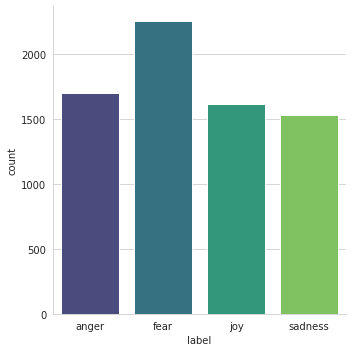

In [6]:
# plotting the distribution of emotions
sns.catplot(x="label", kind="count", palette="viridis", data=train)

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def visualize(label):
    words = ''
    for tweet in train[train['label'] == label]['text']:
        tweet = tweet.lower()
        words += tweet + ' '
    wordcloud = WordCloud(width=1000, height=1000, random_state=1, background_color='white').generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

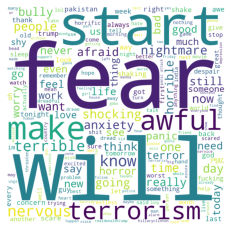

In [ ]:
visualize('fear')

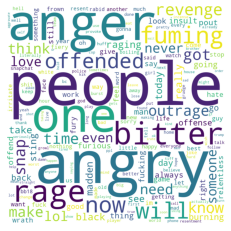

In [ ]:
visualize('anger')

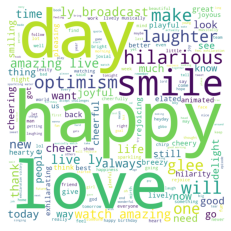

In [ ]:
visualize('joy')

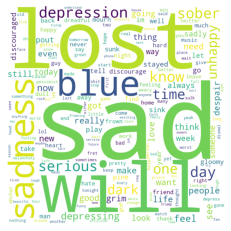

In [ ]:
visualize('sadness')

In [152]:
# splitting into training and development sets
X_train, X_test, y_train , y_test = train_test_split(train,
                                                    train["label"],
                                                    stratify = np.array(train["label"]),
                                                    train_size=0.75, random_state = 42)

In [9]:
# uploading song lyrics dataset 
lyrics = pd.read_csv('https://raw.githubusercontent.com/angelinakhatiwada/Emotion-Detection-in-Song-Lyrics/main/datasets/song_lyrics_final_manually_labeled.csv', index_col =0)
lyrics['song_lyrics'] = lyrics['song_lyrics'].str.replace('EmbedShare URLCopyEmbedCopy', '')
lyrics = lyrics.rename(columns={'song_lyrics': "text"})
lyrics = lyrics.drop_duplicates()
print(lyrics.shape)

(600, 9)


In [153]:
# 40 manually labeled songs for testing
X_test_lyrics = lyrics[lyrics['label'].notnull()]
y_test_lyrics = X_test_lyrics['label']
X_test_lyrics.shape

(40, 11)

### Text processing

In [11]:
#Create CleanText transformer: lowercase, removing numbers, symbols, punctuation, english stopwords
class CleanText( BaseEstimator, TransformerMixin ):
    
    def __init__( self ):
        return 
    
    def fit( self, X, y = None ):
        return self 
    
    def clean( self, x ):
        stop = stopwords.words("english")
        stop = stop + list(string.punctuation)
        words  = [w for w in word_tokenize(x.lower()) if w.isalpha() and w not in stop]
        return " ".join(words)

    def transform( self, X, y = None ):
        return X["text"].apply(self.clean)

In [12]:
# Tf-IDF: unigrams and bigrams
tfidf_uni_bi = TfidfVectorizer(use_idf=True, min_df=2,
                analyzer='word',
                tokenizer=word_tokenize,
                ngram_range = (1,2))

In [13]:
# TF-IDF: char analyzer (3,6)
tfidf_char = TfidfVectorizer(use_idf=True, min_df=2,
                analyzer='char',
                ngram_range = (3,6))

In [154]:
# creating pipelines
pipe_cleaning = Pipeline([('clean', CleanText())])                      
                
pipe_extract_word = Pipeline([('clean', CleanText()), ('tfidf', tfidf_uni_bi)])

pipe_extract_char = Pipeline([('clean', CleanText()), ('tfidf', tfidf_char),
                              ("select", SelectKBest(score_func = chi2, k=15000))])

pipe_extract_char2 = Pipeline([('clean', CleanText()), ('tfidf', tfidf_char)])

In [155]:
tfidf_matrix_train_word = pipe_extract_word.fit_transform(X_train)
tfidf_matrix_test_word = pipe_extract_word.transform(X_test)
print(tfidf_matrix_train_word.shape)
print(tfidf_matrix_test_word.shape)

(5326, 10970)
(1776, 10970)


In [156]:
tfidf_matrix_train_char = pipe_extract_char.fit_transform(X_train, y_train)
tfidf_matrix_test_char = pipe_extract_char.transform(X_test)
print(tfidf_matrix_train_char.shape)
print(tfidf_matrix_test_char.shape)

(5326, 15000)
(1776, 15000)


In [157]:
lyrics['text'] = lyrics['text'].astype(str)
tfidf_matrix_train_lyrics_word = pipe_extract_word.fit_transform(lyrics)
print(tfidf_matrix_train_lyrics_word.shape)

(600, 8149)


In [159]:
tfidf_matrix_train_char2 = pipe_extract_char2.fit_transform(X_train, y_train)
tfidf_matrix_test_char2 = pipe_extract_char2.transform(X_test)
print(tfidf_matrix_train_char2.shape)
print(tfidf_matrix_test_char2.shape)

(5326, 112987)
(1776, 112987)


In [158]:
lyrics['text'] = lyrics['text'].astype(str)
tfidf_matrix_train_lyrics_word = pipe_extract_char2.fit_transform(lyrics)
print(tfidf_matrix_train_lyrics_word.shape)

(600, 99816)


In [47]:
cv = RepeatedKFold(n_splits=10, n_repeats= 5, random_state=1)

### Logistic Regression

TF-IDF vectorizer: Word analyzer


Accuracy score in validation set is,  0.868 with standard deviation =  0.0131 


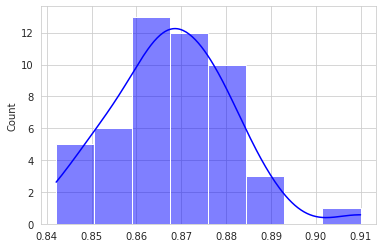

In [ ]:
model = LogisticRegression()
scores = cross_val_score(model, tfidf_matrix_train_word, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [ ]:
pipe_logistic = Pipeline([('pre_process', pipe_extract_word),
                          ('classify', LogisticRegression())])

pipe_logistic.fit(X=X_train, y=y_train)
y_preds = pipe_logistic.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.91      0.83      0.87       426
        fear       0.81      0.93      0.86       563
         joy       0.94      0.90      0.92       404
     sadness       0.86      0.80      0.83       383

    accuracy                           0.87      1776
   macro avg       0.88      0.86      0.87      1776
weighted avg       0.87      0.87      0.87      1776



In [ ]:
y_pred_lyrics = pipe_logistic.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.71      0.50      0.59        10
        fear       0.45      0.50      0.48        10
         joy       0.78      0.70      0.74        10
     sadness       0.54      0.70      0.61        10

    accuracy                           0.60        40
   macro avg       0.62      0.60      0.60        40
weighted avg       0.62      0.60      0.60        40



TF-IDF vectorizer: char analyzer + Feature Selection

Accuracy score in validation set is,  0.858 with standard deviation =  0.0155 


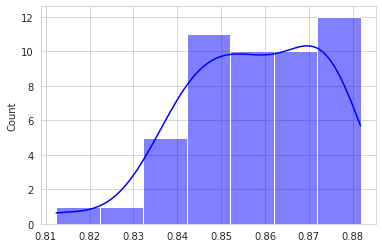

In [ ]:
scores = cross_val_score(model, tfidf_matrix_train_char, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [ ]:
pipe_logistic = Pipeline([('pre_process', pipe_extract_char),
                          ('classify', LogisticRegression())])

pipe_logistic.fit(X=X_train, y=y_train)
y_preds = pipe_logistic.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.90      0.80      0.85       426
        fear       0.76      0.93      0.84       563
         joy       0.93      0.89      0.91       404
     sadness       0.87      0.74      0.80       383

    accuracy                           0.85      1776
   macro avg       0.86      0.84      0.85      1776
weighted avg       0.86      0.85      0.85      1776



In [ ]:
y_pred_lyrics = pipe_logistic.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.88      0.70      0.78        10
        fear       0.47      0.80      0.59        10
         joy       0.67      0.60      0.63        10
     sadness       0.67      0.40      0.50        10

    accuracy                           0.62        40
   macro avg       0.67      0.62      0.63        40
weighted avg       0.67      0.62      0.63        40



### SVM
TF-IDF vectorizer: Word analyzer


Accuracy score in validation set is,  0.865 with standard deviation =  0.0144 


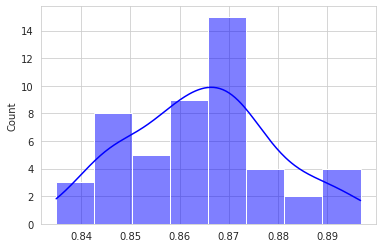

In [ ]:
model = SVC()
scores = cross_val_score(model, tfidf_matrix_train_word, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [ ]:
pipe_svm = Pipeline([('pre_process', pipe_extract_word),
                          ('classify', SVC())])

pipe_svm.fit(X=X_train, y=y_train)
y_preds = pipe_svm.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.91      0.85      0.88       426
        fear       0.81      0.93      0.87       563
         joy       0.95      0.90      0.92       404
     sadness       0.87      0.78      0.82       383

    accuracy                           0.87      1776
   macro avg       0.88      0.87      0.87      1776
weighted avg       0.88      0.87      0.87      1776



In [ ]:
y_pred_lyrics = pipe_svm.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.45      0.50      0.48        10
        fear       0.50      0.60      0.55        10
         joy       0.86      0.60      0.71        10
     sadness       0.50      0.50      0.50        10

    accuracy                           0.55        40
   macro avg       0.58      0.55      0.56        40
weighted avg       0.58      0.55      0.56        40



TF-IDF vectorizer: Char analyzer

Accuracy score in validation set is,  0.894 with standard deviation =  0.0138 


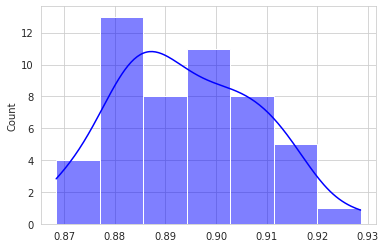

In [ ]:
model = SVC()
scores = cross_val_score(model, tfidf_matrix_train_char, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [ ]:
pipe_svm = Pipeline([('pre_process', pipe_extract_char),
                          ('classify', SVC())])

pipe_svm.fit(X=X_train, y=y_train)
y_preds = pipe_svm.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.91      0.81      0.85       426
        fear       0.81      0.93      0.86       563
         joy       0.95      0.92      0.93       404
     sadness       0.84      0.80      0.82       383

    accuracy                           0.87      1776
   macro avg       0.88      0.86      0.87      1776
weighted avg       0.87      0.87      0.87      1776



In [ ]:
y_pred_lyrics = pipe_svm.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.67      0.40      0.50        10
        fear       0.33      0.60      0.43        10
         joy       1.00      0.30      0.46        10
     sadness       0.38      0.50      0.43        10

    accuracy                           0.45        40
   macro avg       0.60      0.45      0.46        40
weighted avg       0.60      0.45      0.46        40



### SDGClassifier

TF-IDF vectorizer: Word analyzer

Accuracy score in validation set is,  0.877 with standard deviation =  0.0148 


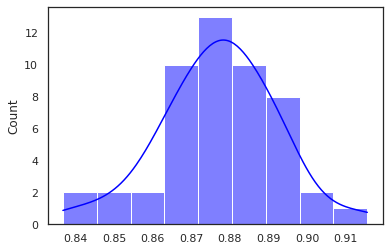

In [162]:
model = SGDClassifier(random_state = 0, loss = 'log', early_stopping=True, class_weight='balanced')
scores = cross_val_score(model, tfidf_matrix_train_word, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [171]:
pipe_sgd = Pipeline([('pre_process', pipe_extract_word),
                          ('classify', SGDClassifier(random_state = 0, loss = 'log', early_stopping=True, class_weight='balanced'))])

pipe_sgd.fit(X=X_train, y=y_train)
y_preds = pipe_sgd.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.91      0.87      0.89       426
        fear       0.87      0.89      0.88       563
         joy       0.91      0.93      0.92       404
     sadness       0.84      0.84      0.84       383

    accuracy                           0.88      1776
   macro avg       0.88      0.88      0.88      1776
weighted avg       0.88      0.88      0.88      1776



In [172]:
y_pred_lyrics = pipe_sgd.predict(X_test_lyrics)
print(classification_report(y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.60      0.60      0.60        10
        fear       0.67      0.40      0.50        10
         joy       0.78      0.70      0.74        10
     sadness       0.47      0.70      0.56        10

    accuracy                           0.60        40
   macro avg       0.63      0.60      0.60        40
weighted avg       0.63      0.60      0.60        40



TF-IDF vectorizer: Char + Feature selection

Accuracy score in validation set is,  0.878 with standard deviation =  0.0153 


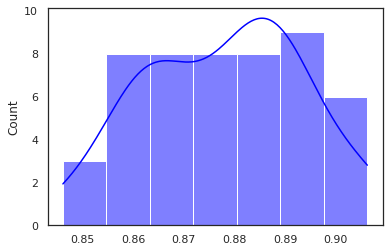

In [166]:
model = SGDClassifier(random_state = 0, loss = 'log', early_stopping=True, class_weight='balanced')
scores = cross_val_score(model, tfidf_matrix_train_char, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Accuracy score in validation set is, {np.mean(scores) : .3f} with standard deviation = {np.std(scores) : .4f} ")
ax = sns.histplot(x=scores, kde=True, color = 'blue')

In [176]:
pipe_sgd = Pipeline([('pre_process', pipe_extract_char),
                          ('classify', SGDClassifier(random_state = 0, loss = 'log', early_stopping=True, class_weight='balanced'))])

pipe_sgd.fit(X=X_train, y=y_train)
y_preds = pipe_sgd.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       anger       0.87      0.82      0.85       426
        fear       0.83      0.88      0.86       563
         joy       0.91      0.91      0.91       404
     sadness       0.84      0.83      0.83       383

    accuracy                           0.86      1776
   macro avg       0.86      0.86      0.86      1776
weighted avg       0.86      0.86      0.86      1776



['anger', 'fear', 'joy', 'sadness']


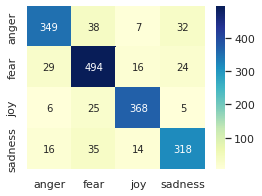

In [177]:
# confusion matrix for dev set
categories = list(set(list(train['label'])))
categories.sort()
print(categories)
df_cm  = pd.DataFrame(confusion_matrix(y_test, y_preds), range(4), range(4))
plt.figure(figsize= (4,3))
sns.set(font_scale=1)
sns.heatmap(df_cm, annot = True, annot_kws={"size":10},xticklabels= categories, yticklabels = categories, cmap ='YlGnBu', fmt='g' )
plt.show()

In [178]:
y_pred_lyrics = pipe_sgd.predict(X_test_lyrics)
print(classification_report( y_test_lyrics, y_pred_lyrics))

              precision    recall  f1-score   support

       anger       0.73      0.80      0.76        10
        fear       0.60      0.60      0.60        10
         joy       0.71      0.50      0.59        10
     sadness       0.58      0.70      0.64        10

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.65        40
weighted avg       0.66      0.65      0.65        40



['anger', 'fear', 'joy', 'sadness']


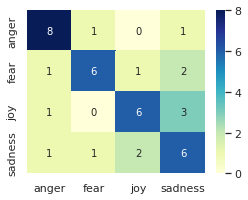

In [170]:
# confusion matrix for test set with song lyrics
categories = list(set(y_train))
categories.sort()
print(categories)
df_cm_lyrics  = pd.DataFrame(confusion_matrix(y_test_lyrics, y_pred_lyrics), range(4), range(4))
plt.figure(figsize= (4,3))
sns.set(font_scale=1)
sns.heatmap(df_cm_lyrics, annot = True, annot_kws={"size":10},xticklabels= categories, yticklabels = categories, cmap ='YlGnBu', fmt='g' )
plt.show()

### LSTM : Keras

In [125]:
#Create CleanText transformer: lowercase, removing numbers, symbols, punctuation, stopwords not removed
class CleanText2( BaseEstimator, TransformerMixin ):
    
    def __init__( self ):
        return 
    
    def fit( self, X, y = None ):
        return self 
    
    def clean( self, x ):
        stop = list(string.punctuation)
        words  = [w for w in word_tokenize(x.lower()) if w.isalpha() and w not in stop]
        return " ".join(words)

    def transform( self, X, y = None ):
        return X["text"].apply(self.clean)

# creating pipelines
pipe_cleaning_stop = Pipeline([('clean', CleanText2())]) 

In [131]:
X_train, X_test, y_train , y_test = train_test_split(train,
                                                    train["label"],
                                                    stratify = np.array(train["label"]),
                                                    train_size=0.75, random_state = 42)

X_test_lyrics = lyrics[lyrics['label'].notnull()]
y_test_lyrics = X_test_lyrics['label']

In [132]:
# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 20000
# Max number of words in each tweet/song
MAX_SEQUENCE_LENGTH = 1000
# emdedding dimensions
EMBEDDING_DIM = 200

#### Stopwords removed

In [133]:
X_train['cleaned_text'] =  pipe_cleaning.fit_transform(X_train)
X_test['cleaned_text'] = pipe_cleaning.transform(X_test)
X_test_lyrics['cleaned_text'] = pipe_cleaning.transform(X_test_lyrics)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train['cleaned_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train = tokenizer.texts_to_sequences(X_train['cleaned_text'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train data tensor:', X_train.shape)

X_test = tokenizer.texts_to_sequences(X_test['cleaned_text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', X_test.shape)

X_test_lyrics = tokenizer.texts_to_sequences(X_test_lyrics['cleaned_text'].values)
X_test_lyrics = pad_sequences(X_test_lyrics, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test lyrics data tensor:', X_test_lyrics.shape)

Y_train = pd.get_dummies(y_train).values
print('Shape of train label tensor:', Y_train.shape)

Y_test= pd.get_dummies(y_test).values
print('Shape of test label tensor:', Y_test.shape)

Y_test_lyrics= pd.get_dummies(y_test_lyrics).values
print('Shape of test lyrics label tensor:', Y_test_lyrics.shape)

Found 11856 unique tokens.
Shape of train data tensor: (5326, 1000)
Shape of test data tensor: (1776, 1000)
Shape of test lyrics data tensor: (40, 1000)
Shape of train label tensor: (5326, 4)
Shape of test label tensor: (1776, 4)
Shape of test lyrics label tensor: (40, 4)


In [140]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         4000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1000, 200)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 4,120,804
Trainable params: 4,120,804
Non-trainable params: 0
_________________________________________________________________
None


In [141]:
epochs = 5
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1)

Epoch 1/5
38/38 [==============================] - 233s 6s/step - loss: 1.3436 - accuracy: 0.3380 - val_loss: 1.2558 - val_accuracy: 0.5009
Epoch 2/5
38/38 [==============================] - 230s 6s/step - loss: 0.8738 - accuracy: 0.7281 - val_loss: 0.6789 - val_accuracy: 0.7955
Epoch 3/5
38/38 [==============================] - 231s 6s/step - loss: 0.2864 - accuracy: 0.9282 - val_loss: 0.4918 - val_accuracy: 0.8593
Epoch 4/5
38/38 [==============================] - 230s 6s/step - loss: 0.1283 - accuracy: 0.9629 - val_loss: 0.4472 - val_accuracy: 0.8630
Epoch 5/5
38/38 [==============================] - 229s 6s/step - loss: 0.0920 - accuracy: 0.9679 - val_loss: 0.4454 - val_accuracy: 0.8687


In [142]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy test tweets: {:0.3f}'.format(accr[0],accr[1]))

56/56 [==============================] - 18s 326ms/step - loss: 0.4496 - accuracy: 0.8671
Test set
  Loss: 0.450
  Accuracy test tweets: 0.867


In [143]:
accr = model.evaluate(X_test_lyrics,Y_test_lyrics)
print('Test set\n  Loss: {:0.3f}\n  Accuracy test lyrics: {:0.3f}'.format(accr[0],accr[1]))

2/2 [==============================] - 1s 198ms/step - loss: 2.4244 - accuracy: 0.4250
Test set
  Loss: 2.424
  Accuracy test lyrics: 0.425


#### Stopwords not removed

In [144]:
X_train, X_test, y_train , y_test = train_test_split(train,
                                                    train["label"],
                                                    stratify = np.array(train["label"]),
                                                    train_size=0.75, random_state = 42)

X_test_lyrics = lyrics[lyrics['label'].notnull()]
y_test_lyrics = X_test_lyrics['label']

In [145]:
X_train['cleaned_text'] =  pipe_cleaning_stop.fit_transform(X_train)
X_test['cleaned_text'] = pipe_cleaning_stop.transform(X_test)
X_test_lyrics['cleaned_text'] = pipe_cleaning_stop.transform(X_test_lyrics)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train['cleaned_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train = tokenizer.texts_to_sequences(X_train['cleaned_text'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train data tensor:', X_train.shape)

X_test = tokenizer.texts_to_sequences(X_test['cleaned_text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', X_test.shape)

X_test_lyrics = tokenizer.texts_to_sequences(X_test_lyrics['cleaned_text'].values)
X_test_lyrics = pad_sequences(X_test_lyrics, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test lyrics data tensor:', X_test_lyrics.shape)

Y_train = pd.get_dummies(y_train).values
print('Shape of train label tensor:', Y_train.shape)

Y_test= pd.get_dummies(y_test).values
print('Shape of test label tensor:', Y_test.shape)

Y_test_lyrics= pd.get_dummies(y_test_lyrics).values
print('Shape of test lyrics label tensor:', Y_test_lyrics.shape)

Found 11996 unique tokens.
Shape of train data tensor: (5326, 1000)
Shape of test data tensor: (1776, 1000)
Shape of test lyrics data tensor: (40, 1000)
Shape of train label tensor: (5326, 4)
Shape of test label tensor: (1776, 4)
Shape of test lyrics label tensor: (40, 4)


In [146]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 200)         4000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1000, 200)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 4,120,804
Trainable params: 4,120,804
Non-trainable params: 0
_________________________________________________________________
None


In [147]:
epochs = 5
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1)

Epoch 1/5
38/38 [==============================] - 233s 6s/step - loss: 1.3538 - accuracy: 0.3165 - val_loss: 1.2863 - val_accuracy: 0.4334
Epoch 2/5
38/38 [==============================] - 230s 6s/step - loss: 0.9538 - accuracy: 0.6891 - val_loss: 0.7793 - val_accuracy: 0.7786
Epoch 3/5
38/38 [==============================] - 230s 6s/step - loss: 0.3340 - accuracy: 0.9207 - val_loss: 0.5264 - val_accuracy: 0.8330
Epoch 4/5
38/38 [==============================] - 233s 6s/step - loss: 0.1392 - accuracy: 0.9599 - val_loss: 0.4705 - val_accuracy: 0.8518
Epoch 5/5
38/38 [==============================] - 230s 6s/step - loss: 0.0978 - accuracy: 0.9679 - val_loss: 0.5128 - val_accuracy: 0.8386


In [148]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy test tweets: {:0.3f}'.format(accr[0],accr[1]))

56/56 [==============================] - 18s 324ms/step - loss: 0.4781 - accuracy: 0.8525
Test set
  Loss: 0.478
  Accuracy test tweets: 0.852


In [149]:
accr = model.evaluate(X_test_lyrics,Y_test_lyrics)
print('Test set\n  Loss: {:0.3f}\n  Accuracy test lyrics: {:0.3f}'.format(accr[0],accr[1]))

2/2 [==============================] - 1s 202ms/step - loss: 1.9528 - accuracy: 0.4000
Test set
  Loss: 1.953
  Accuracy test lyrics: 0.400


### Classifying the entire lyrics dataset with best classifier (SGDClassifier)

In [179]:
# predicting talikng the best classifier
best_classifier = pipe_sgd
lyrics['text'] = lyrics['text'].astype(str)
y_pred_lyrics_all = pipe_sgd.predict(lyrics)
lyrics['emotion_pred'] = y_pred_lyrics_all

In [180]:
# SGD probablity score
y_score = pipe_sgd.predict_proba(lyrics)
score_emot_selected = np.round(np.amax(y_score, 1)*1, 2)
score_emot_selected.shape
lyrics['emotion_score'] = score_emot_selected

In [181]:
lyrics_genres = lyrics.groupby('genre')['emotion_pred'].value_counts(normalize=True).reset_index(name='percentage')

In [120]:
# percentage of emotion classed predicted in the lyrics dataset
lyrics['emotion_pred'].value_counts(normalize=True)

sadness    0.353333
fear       0.251667
anger      0.203333
joy        0.191667
Name: emotion_pred, dtype: float64

In [121]:
# percentage of emotion classed predicted in the lyrics dataset by genres
lyrics_genres

,genre,emotion_pred,percentage
0,Alternative Rock/Indie,sadness,0.312500
1,Alternative Rock/Indie,fear,0.300000
2,Alternative Rock/Indie,anger,0.250000
3,Alternative Rock/Indie,joy,0.137500
4,Blues,sadness,0.550000
5,Blues,anger,0.200000
6,Blues,fear,0.150000
7,Blues,joy,0.100000
8,Classic Rock,sadness,0.360000
9,Classic Rock,fear,0.280000


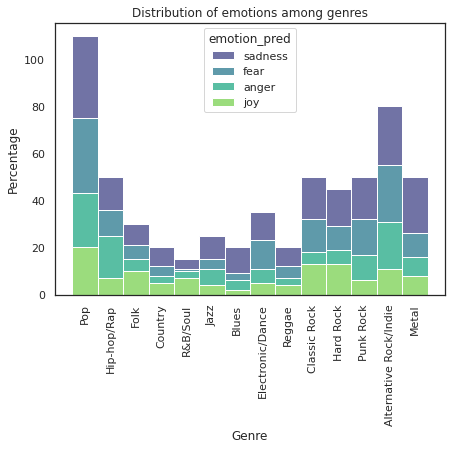

In [123]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
sns.set_style("white")

sns.histplot(data=lyrics, ax=ax, stat="count", multiple="stack",
             x="genre", kde=False,
             palette='viridis', hue="emotion_pred",
             element="bars", legend=True)
ax.set_title("Distribution of emotions among genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.tick_params(axis='x', rotation=90)

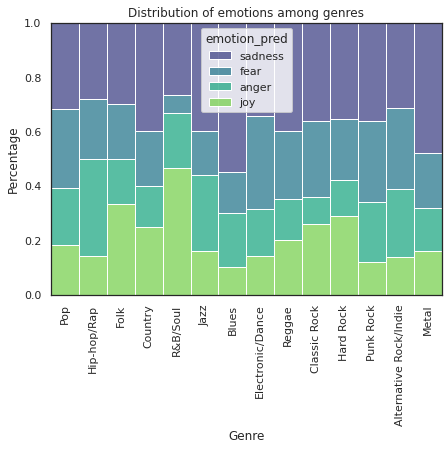

In [124]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1) 
sns.set_style("white")

sns.histplot(data=lyrics, ax=ax, stat="percent", multiple="fill",
             x="genre", kde=False,
             palette='viridis', hue="emotion_pred",
             element="bars", legend=True)
ax.set_title("Distribution of emotions among genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.tick_params(axis='x', rotation=90)

In [128]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [129]:
#lyrics.to_csv('/content/drive/MyDrive/song_lyrics_labeled.csv')